
## Hands on Machine Learning chapter 06 실습
Decision Tree

Decision tree can be used for regression or classification

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 분류 트리

decision tree의 흐름을 시각화로 확인할 수 있다.

In [2]:
# 훈련 및 시각화
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)# max_depth: 트리의 깊이 설정
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

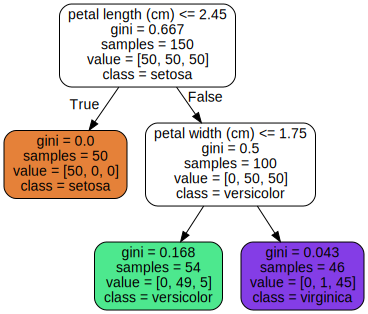

In [3]:
# decision tree의 결과는 graphviz를 통해 시각화 한다.
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

# root node (시작) --> leaf node (결과)
# root node에서부터 branch를 (자식node로) 뻗어나아가서 결과를 leaf node에서 확인
# gini(불순도) = 0.0: 순수 node
# 이렇게 훈련된 decision tree 모델은 새로운 데이터가 주어졌을때에,
# 동일한 조건으로 (petal length <=2.45 , petal width <=1.75) 분별해서 예측 결과를 leaf node에 출력한다.

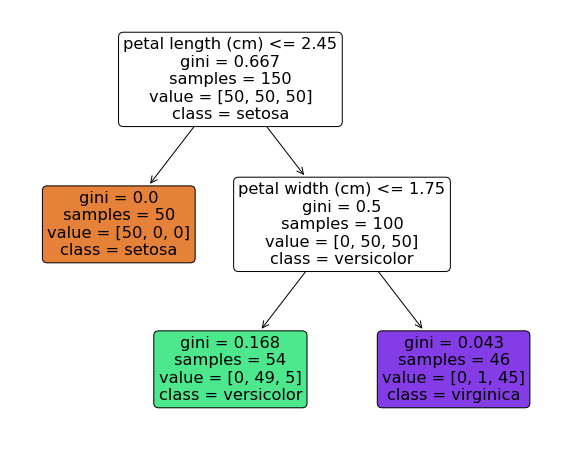

In [5]:
# sklearn에 decision tree 시각화 함수가 포함되었다

from sklearn.tree import plot_tree

plt.figure(figsize=(10,8)) #그냥 그리면 너무 작게나와서 크기 조절
plot_tree(tree_clf, filled=True, rounded=True,
          feature_names=iris.feature_names[2:],
          class_names=iris.target_names)
plt.show()

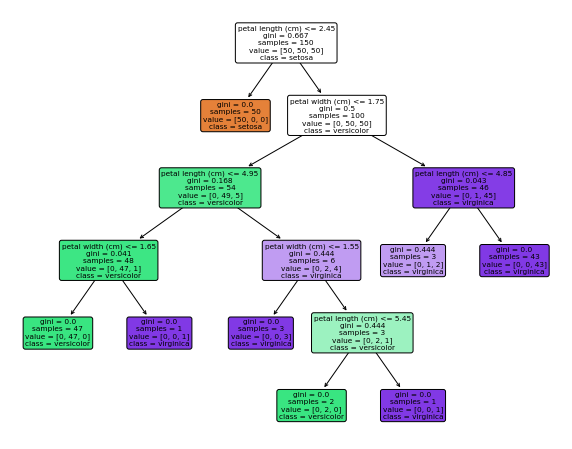

In [16]:
# 만약 max_depth 설정하지 않는다면(max_depth: 트리의 깊이 설정):
# 트리의 깊이(성장 깊이)에 제한이 없기때문에 leaf node의 불순도가 0이 될때까지 다보여준다.

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X, y)

plt.figure(figsize=(10,8))
plot_tree(tree_clf, filled=True, rounded=True,
          feature_names=iris.feature_names[2:],
          class_names=iris.target_names)
plt.show()

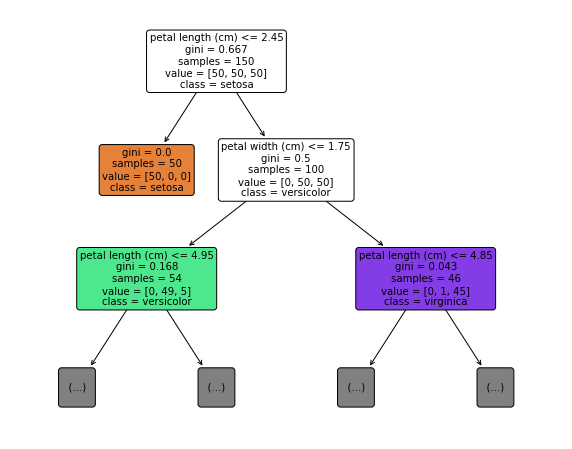

In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X, y)

plt.figure(figsize=(10,8))
plot_tree(tree_clf, filled=True, rounded=True, max_depth=2,
          feature_names=iris.feature_names[2:],
          class_names=iris.target_names)
plt.show()

보고서에 활용하기 좋은 모델이지만,
tree dpeth가 깊어지면 복잡해지기때문에
적절한 수준의 tree model을 시각화에 사용하는것이 좋다.

**지니 불순도**

$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}
$


gini 불순도 계산 예시: 

petal length <=4.95cm 조건의 node에서의 gini

0.168 = 1 - ((0/54)^2 + (49/54)^2 + (5/54)^2)


**엔트로피 불순도**

$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$

gini 불순도 계산 예시: 

0.168 = - ((0/54)*log2(0/54) + (49/54)*log2(49/54) + (5/54)*log2(5/54))


In [ ]:
DecisionTreeClassifier(criterion='entropy') # gini를 사용하는것과 대소동이함


**분류에 대한 CART 비용 함수**

$
\begin{split}
&J(k, t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}\\
&\text{여기에서 }\begin{cases}
G_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 불순도}\\
m_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 샘플 수}
\end{cases}
\end{split}
$

그림 저장: decision_tree_decision_boundaries_plot


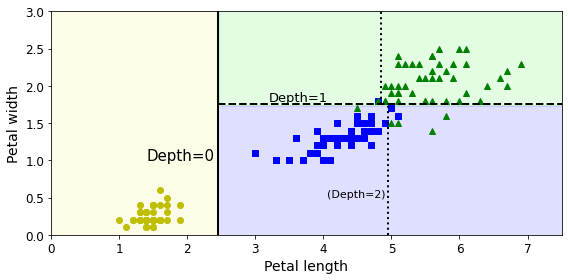

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

# petal length 기준으로 나누고 (solid line division)
# 그 다음 petal width 기준으로 나눔 (dashed line division)
# 그 이후 (dotted line division)

#### class & class probability 예측

In [4]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [5]:
tree_clf.predict([[5, 1.5]])

array([1])

#### 훈련 세트에 민감함

In [6]:
# versicolor중에서 길이 4.8,폭 1.8인 sample을 하나 빼기위함

X[(X[:,1]==X[:,1][y==1].max()) & (y==1)] # widest Iris versicolor flower

array([[4.8, 1.8]])

In [7]:
not_widest_versicolor = (X[:,1] != 1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=40, splitter='best')

#### 높은 분산 

샘플을 하나 뺐을 뿐인데, algorithm이 petal legnth 특성을 사용하지않고, petal width만 사용했고, 결정 경계가 아얘 달라졌다. 

그림 저장: decision_tree_instability_plot


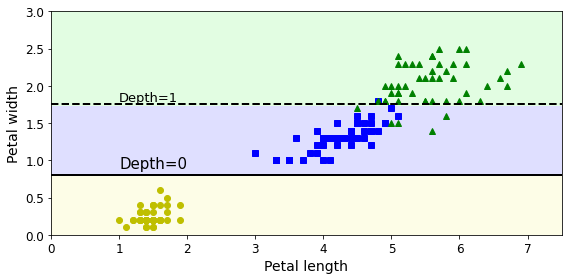

In [12]:

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X, y, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

훈련 데이터 셋을 모두 사용한 decision tree algorithm은 과대적합이 될 위험이 크다. 

그래서 모델에 적절하게 규제가 주어져야한다. "사전 가지치기" 라고 부르기도 한다.

그림 저장: min_samples_leaf_plot


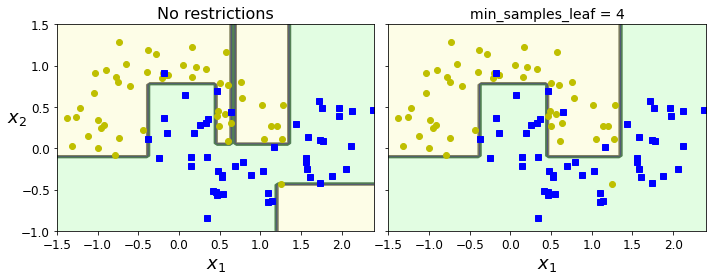

In [13]:
# min_samples_leaf로 규제하는 경우
# min_samples_leaf= 정수(원하는 min 샘플 개수), 실수(전체 샘플중의 비율)

from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
# min_samples_leaf=4 : leaf node가 될 최소 sample의 개수
# 어느 node가 자식 node로 divide되었을때, 하나의 자식 node로 분류된 샘플의 갯수가 4개이하이면 
# 더이상 계속해서 tree를 성장시키지 않고 현재 상태에서 leaf node로 마무리 한다.
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

# 결과적으로 restriction을 주지않은 경우 샘플 분류가 어려울 정도의 매우 복잡한 boundary가 그려지고,
# min_smaple_leaf를 통해 규제를 가하면 보다 더 나누기 적합한 boundary가 그려진다.

Tree 모델의 gini 불순도나, entropy 불순도를 계산할때에 특성값을 사용하지않고, 샘플의 비율을 사용한다.

특성값을 사용하지 않는다는 것은 "거리"의 개념이 들어가지 않아도 된다는 것을 의미함.

decision tree 모델은 data의 전처리가 필요하지 않은 장점을 가지고있다.

note: randomforest와 같은 ensemble 모델이나 tree모델은 과대적합될 위험이 더 큰 특징을 갖고있다. 규제가 반드시 필요함.

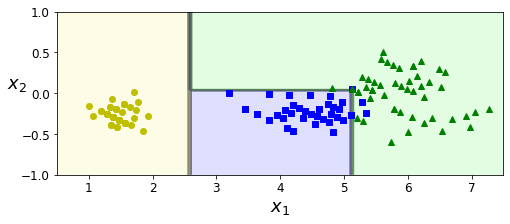

In [14]:
# 데이터 셋의 축의 회전에 따라 경계boundary가 달라진다.

angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

그림 저장: sensitivity_to_rotation_plot


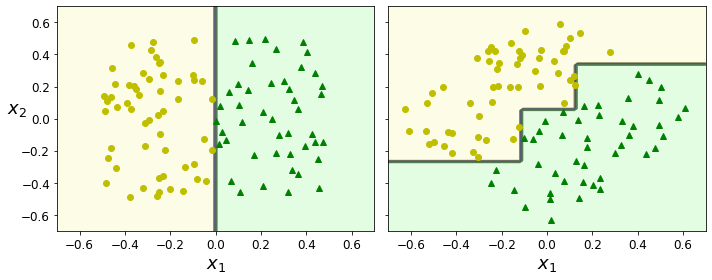

In [15]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

## 회귀 트리

In [16]:
# y target값을 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [17]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

그림 저장: tree_regression_plot


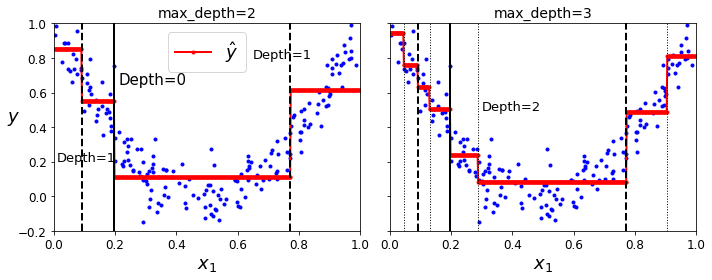

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

# max_depth=2의 경우: 빨간색은 예측 값 (leaf node의 평균 값) leaf node 4개가 빨간 marking으로 그려졌다.

In [19]:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

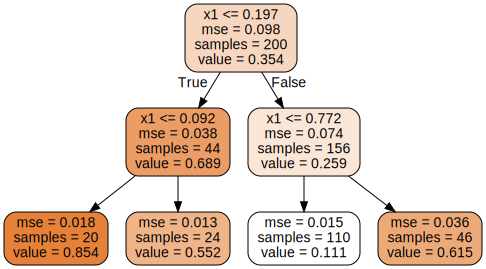

In [20]:
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

# 기본이 mse(mean square error)로 지정되어있다. 
# value 값은 예측 값 (value 값에 따라서 node의 색깔의 짙음이 달라짐)

그림 저장: tree_regression_regularization_plot


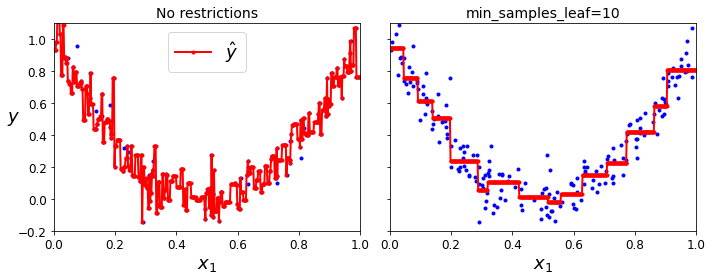

In [21]:
# 회귀 트리 모델

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

# 규제를 하지 않는 경우 - leaf node가 매우 많다. 과대적합 문제
# 규제를 하는 경우 - 더 적절한 예측을 할 수 있음.